In [26]:
%config InlineBackend.figure_format = 'retina'

In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import threading
import warnings
from typing import Tuple, List
import warnings
warnings.filterwarnings("ignore")
threading.stack_size(67108864)

67108864

# **Solving Systems of Linear Algebraic Equations**

## **0. Functional and helpers**

In [28]:
def get_true_x(n: int) -> np.array:
    assert n > 0, "Parameter n should be positive integer"
    return np.arange(1, n + 1)

In [29]:
def get_matrix_cond(A: np.array) -> float:
    svd = np.linalg.svd(A, compute_uv=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        cond = np.fabs(np.max(svd) / np.min(svd))
        return cond if cond != float("inf") else -1

In [30]:
def generate_matrix(n: int, k: float) -> np.array:
    A = np.random.choice([-4., -3., -2., -1., 0.], size=(n, n))
    np.fill_diagonal(A, 0)
    diagonal = np.zeros(n)
    for i in range(n):
        diagonal[i] = np.sum(abs(A[i, :]))
    diagonal[0] += 10 ** -k
    np.fill_diagonal(A, diagonal)
    return np.array(A) if get_matrix_cond(A) != -1 else generate_matrix(n, k)

In [31]:
def get_hilbert_matrix(n: int, k: float) -> np.array:
    a = np.array([[1 / (i + j + 1) for j in range(n)] for i in range(n)])
    a[0, 0] += 10 ** -k
    return a

In [32]:
def solve_for_matrix_with_method(n: int, k: float, method, gen_method, logs=False) -> np.array:
    A = gen_method(n, k)
    b = A @ get_true_x(len(A))
    if logs:
        print(f'Solving:\n{A} @ x = {b}')
    x = method(A, b)
    if logs:
        print(f'Solution: x = {x}')
    return x

## **1. Implement Gauss method with leading element selection**

The Gaussian elimination is perhaps one of the most popular method. One of the reasons for its widespread use can be attributed to the simplicity of the algorithm.
The process of solving a system of equations can be divided into two phases: forward and backward passes.

**Matrix requirements:**
- square
- matrix rank equal to the number of rows
---

**Forward pass**

*Task: Bring the system to a upper triangular matrix so that all elements below the main diagonal are equal to 0.*

**Algorithm essence:**

There is a linear system of the following semantics:
$$
\begin{cases}
      a_{11}x_1 + a_{12}x_2 + ... + a_{1n}x_n = b_1\\
      a_{21}x_1 + a_{22}x_2 + ... + a_{2n}x_n = b_2\\
      ...\\
      a_{n1}x_1 + a_{n2}x_2 + ... + a_{nn}x_n = b_n
\end{cases}\
$$

1) Introduce conditional notation:
$$m - \text{the iteration number of the algorithm}$$
$$ m=\overline{1,(n-1)}$$
$$a_{ij}^{(0)} = a_{ij}, \quad b_i^{(0)}=b_i$$ 

2) For each row, perform the following transformation:
$$
a_{ij}^{(m)} = a_{ij}^{(m-1)} - \frac{a_{im}^{(m-1)}}{a_{mm}^{(m-1)}}\cdot a_{mj}^{(m-1)}; \quad \quad \quad i,j=\overline{(m+1), n}
$$
$$
b_i^{(m)}=b_i^{(m-1)} - \frac{a_{im}^{(m-1)}}{a_{mm}^{(m-1)}}\cdot b_m^{(m-1)}; \quad \quad \quad i,j=\overline{(m+1), n}
$$

3) In the end, after $ n - 1 = m $, we will get a triangular system

---

**Backward pass**

*Task: To obtain the values of all variables, starting with the last one.*

**Algorithm essence:**

In the course of linear algebra, we explored this method in sufficient detail, so here, we can limit ourselves to just the general formula:

$$
x_m = \frac{1}{a_{mm}^{(m-1)}}(b_m^{(m-1)} - \sum_{j=m+1}^na_{mj}^{(m-1)}x_j)
$$

In [33]:
def solve_gauss_lead_selection(A: np.array, b: np.array) -> np.array:
    # selecting leading element
    for i in range(n := len(A)):
        pivot_row = i + np.argmax(np.abs(A[i:, i]))
        if i != pivot_row:
            A[[i, pivot_row]], b[[i, pivot_row]] = A[[pivot_row, i]], b[[pivot_row, i]]
        # converting matrix to upper-triangular form
        for iter in range(i + 1, n):
            u = -A[iter][i] / A[i][i]
            A[iter, i:] += u * A[i, i:]
            b[iter] += u * b[i]
    # reverse gauss
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - A[i, i + 1:] @ x[i + 1:]) / A[i, i]
    return x  

In [34]:
solve_for_matrix_with_method(n=4, k=3, method=solve_gauss_lead_selection, gen_method=generate_matrix, logs=True)

Solving:
[[ 4.001 -4.     0.     0.   ]
 [-1.     6.    -2.    -3.   ]
 [-4.    -4.     9.    -1.   ]
 [-1.    -4.    -3.     8.   ]] @ x = [-3.999 -7.    11.    14.   ]
Solution: x = [1. 2. 3. 4.]


array([1., 2., 3., 4.])

## **2. Implement LU-decomposition method**

Let $ A_{n \times n} = |a_{ij}|; \: \: ( i,j = \overline{1,n}\: )$

If $A$ is a nonsingular matrix, then we can find such lower and upper triangular matrices $L$ and $U$, that $A = LU$.

Let's prove that its possible by determining the recursive formula.

---

By defined preconditions, all elements from first row of $L$ matrix and first column of $U$, except, maybe, the first one, is equal to zero.

Then:
$$
a_{11} = l_{11}u_{11}
$$

If $a_{11} = 0$, then $l_{11} = 0$ or $u_{11} = 0$. That means, either $L$ or $U$'s determinant is equal to zero. Therefore, determinant of $A$ is also equal to zero. There is a violation of preconditions.

So, we suppose that $a_{11} \neq 0, l_{11} \neq 0, u_{11} \neq 0 $. Taking into consideration fact that $L$ $U$ definded up to multiplication by a constant, we demand $l_{11} = 1, u_{11} = a_{11}$.

---

Split matrix $A$ into four segments:
$$
A = \begin{pmatrix} a_{11} & \omega^T \\ v & A' \end{pmatrix}
$$
 
$$
a_{11} - first\ element\ of\ A. \\
v = \begin{pmatrix} 
a_{21} \\ 
a_{31} \\ 
.. \\ 
a_{n1} 
\end{pmatrix} \\
\omega^T = \begin{pmatrix} 
a_{12} & a_{13} & .. & a_{1n} 
\end{pmatrix} \\
A' = \begin{pmatrix} 
a_{22} & a_{23} & .. & a_{2n} \\ 
a_{32} & .. & & a_{3n} \\
... \\
a_{n2} & .. & & a_{nn}
 \end{pmatrix} \\
$$

Split matrices $L$ and $U$ the similar way:

$$
L = \begin{pmatrix} 
1 & 0 \\  
v_l & L' 
\end{pmatrix}, \quad
U = \begin{pmatrix} 
a_{11} & \omega^T_u \\  
v_l & L' 
\end{pmatrix}
$$

$$
A = LU \\
\Downarrow \\
\begin{cases}
\omega^T = \omega^T_u \\
v=a_{11}v_l \\
A'=v_l\omega_u^T + L'U'
\end{cases} \\
\Downarrow \\
Solution:
\begin{cases}
\omega_u=\omega \\
v_l=\frac{v}{a_{11}} \\
L'U' = A' - \frac{v\omega^T}{a_{11}}
\end{cases}
$$

We transformed task of $LU$-decomposition of matrix $A$ to easier task of $LU$-decomposition $A'_{(n-1)\times (n-1)}$

Recursive formula is found.

In [35]:
def get_lu_decomposition(A: np.array) -> Tuple[np.array, np.array]:
    n = len(A)
    L, U = np.zeros([n, n]), np.zeros([n, n])
    for i in range(n):
        for k in range(i, n):
            U[i][k] = A[i][k] - sum([L[i][j] * U[j][k] for j in range(i)])
        for k in range(i, n):
            L[k][i] = (A[k][i] - sum([L[k][j] * U[j][i] for j in range(i)])) / U[i][i] if i != k else 1.0
    return L, U

def get_lu_decomposition_vectorized(A: np.array) -> Tuple[np.array, np.array]:
    L = np.eye(n := len(A))
    for i in range(n):
        L[i + 1:, i] = A[i + 1:, i] / A[i, i]
        A[i + 1:, i:] -= L[i + 1:, i, None] * A[i, i:]
    return L, A

In [36]:
test_matrix = np.array([[1., 2., 3.], [4., 5., 6.], [7., 8., 9.]])
test_L, test_U = get_lu_decomposition(test_matrix)
assert np.allclose(test_L @ test_U, test_matrix), "wrong implementation of LU-decomposition"

The LU-decomposition method is very similar to the Gaussian elimination method, but the difference lies in how we interpret the initial matrix. The square matrix is decomposed into a product of a lower triangular matrix (with 1 value on the diagonal) and an upper triangular matrix:
$$
Ax=L(Ux)=b
$$
It is then clear that we can sequentially solve two systems of equations by using Gaussian back-substitution:
$$
Ly=b, \quad Ux=y
$$
This method is also a **direct** and is generally no different from the Gaussian elimination method, except that processing the solution vector directly requires fewer resources. However, this gain transfers to decomposing the initial matrix into a product of two triangular matrices.

In [37]:
def solve_lu_decomposition(A: np.array, b: np.array) -> np.array:
    L, U = get_lu_decomposition(A)
    y = np.zeros(n := len(A))
    for i in range(n):
        y[i] = b[i] - L[i, :i] @ y[:i]
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - U[i, i + 1:] @ x[i + 1:]) / U[i, i]
    return x

In [38]:
solve_for_matrix_with_method(n=8, k=3, method=solve_lu_decomposition, gen_method=generate_matrix, logs=True)

Solving:
[[13.001 -2.    -3.     0.     0.    -3.    -1.    -4.   ]
 [-3.    12.    -4.     0.    -3.    -1.    -1.     0.   ]
 [-2.    -4.    13.     0.     0.    -4.    -2.    -1.   ]
 [-2.     0.    -2.    15.    -4.    -3.    -2.    -2.   ]
 [ 0.    -1.    -3.     0.     8.    -3.    -1.     0.   ]
 [-4.    -4.    -2.    -2.    -1.    14.     0.    -1.   ]
 [-4.    -1.    -4.     0.    -4.     0.    16.    -3.   ]
 [ 0.    -4.    -3.     0.    -4.    -2.    -3.    16.   ]] @ x = [-56.999 -19.    -17.    -16.      4.     45.     50.     58.   ]
Solution: x = [1. 2. 3. 4. 5. 6. 7. 8.]


array([1., 2., 3., 4., 5., 6., 7., 8.])

## **3. Implement iterative Jacobi method**

The Jacobi iterative method involves decomposing the desired matrix into the sum of a diagonal matrix and the matrix obtained by subtracting the diagonal elements. In this case, the equation is written as follows:
$$
Ax=(D+R)x=b
$$
This problem can be interpreted as the iterative one:
$$
Dx=b-Rx \quad \longrightarrow \quad x=D^{-1}b-D^{-1}Rx
$$
Note that for diagonal matrices, finding the inverse matrix is much simpler due to the minors being zero.

---

It should be noted that typically at the beginning of the algorithm, a random vector of values is chosen as a starting point, and the accuracy is then iteratively improved. However, for the convergence analysis, it's important to emphasize that the method is guaranteed to converge only if the desired matrix has diagonal dominance, so:
$$
|a_{ij}|>\sum\limits_{j=1, \: \: j \neq i}^n |a_{ij}| \quad \forall i =1,...,n
$$ 

In [39]:
def solve_jacobi(A: np.array, b: np.array, max_iterations=1e9, eps=1e-6) -> np.array: 
    diag_inv = np.zeros([n := len(A), n])
    np.fill_diagonal(diag_inv, [val ** -1 if val != 0 else eps for val in np.diag(A)])
    np.fill_diagonal(A, 0)
    A = diag_inv @ A
    b = diag_inv @ b
    x = np.zeros(n)
    for iter in range(int(max_iterations)):
        x_curr = b - A @ x
        if np.linalg.norm(x_curr - x) < eps or np.linalg.norm(x_curr) / np.linalg.norm(b) < eps:
            break
        x = x_curr
    return x

In [40]:
solve_for_matrix_with_method(n=4, k=4, method=solve_jacobi, gen_method=generate_matrix, logs=True)

Solving:
[[ 2.0001 -1.      0.     -1.    ]
 [ 0.      6.     -3.     -3.    ]
 [-1.     -3.      4.      0.    ]
 [-1.     -4.     -3.      8.    ]] @ x = [-3.9999 -9.      5.     14.    ]
Solution: x = [0.89999916 1.8999945  2.89999516 3.89999483]


array([0.89999916, 1.8999945 , 2.89999516, 3.89999483])

## **4. Benchmark cond-value in relation to k-value**

In [41]:
def get_clear_seq(seq: List[float]) -> List[float]:
    avg = sum(seq) / len(seq)
    for i in range(1, len(seq) - 1):
        seq[i] = np.mean([seq[i - 1], seq[i + 1]]) if seq[i] > 2 * avg else seq[i]
    return seq

In [42]:
def plot_cond_benchmark(iterations: int, n: int, k_start=-2, k_end=15):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    x_range = np.linspace(k_start, k_end, 50)
    conds = [np.mean(get_clear_seq([get_matrix_cond(generate_matrix(n, k)) for _ in range(iterations)])) for k in x_range]
    ax.scatter(x=x_range, y=get_clear_seq(conds))
    ax.set(xlabel='k value', ylabel='$Cond$', title='Benchmark $cond-value$ plot')
    ax.grid()
    plt.show()

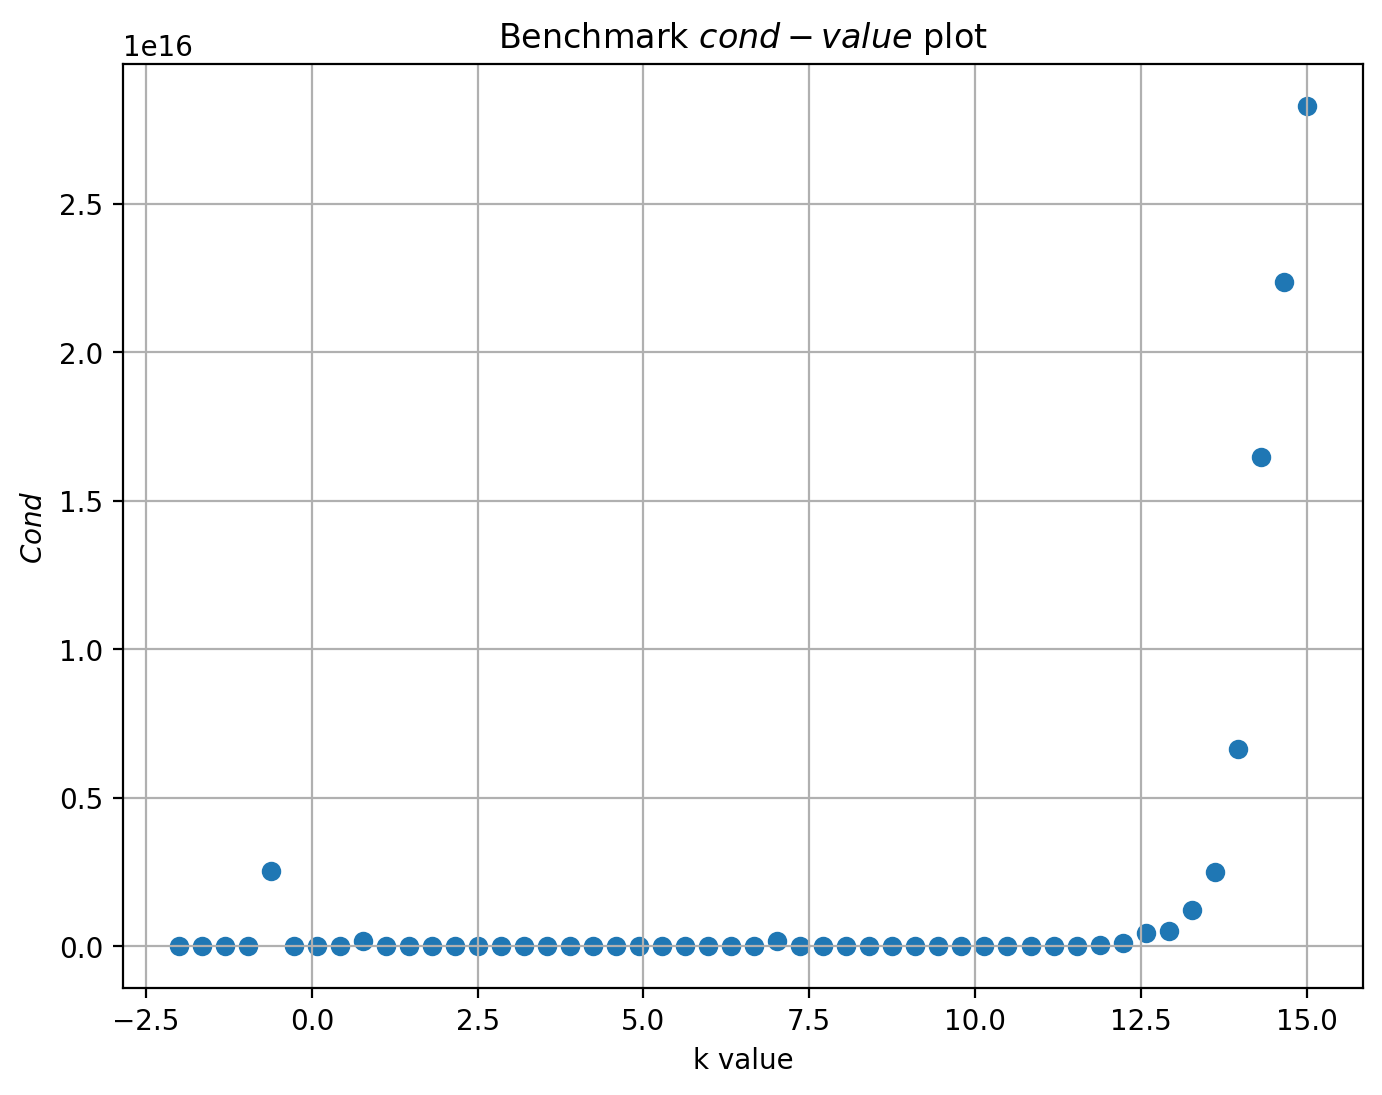

In [43]:
plot_cond_benchmark(iterations=100, n=4)

In [44]:
def plot_cond_benchmark_hilbert(iterations: int, n: int, k_start=-2, k_end=15):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    x_range = np.linspace(k_start, k_end, 50)
    conds = [np.mean(get_clear_seq([get_matrix_cond(get_hilbert_matrix(n, k)) for _ in range(iterations)])) for k in x_range]
    ax.scatter(x=x_range, y=get_clear_seq(conds))
    ax.set(xlabel='k value', ylabel='$Cond$', title='Benchmark $cond-value$ plot on hilbert matrices')
    ax.grid()
    plt.show()

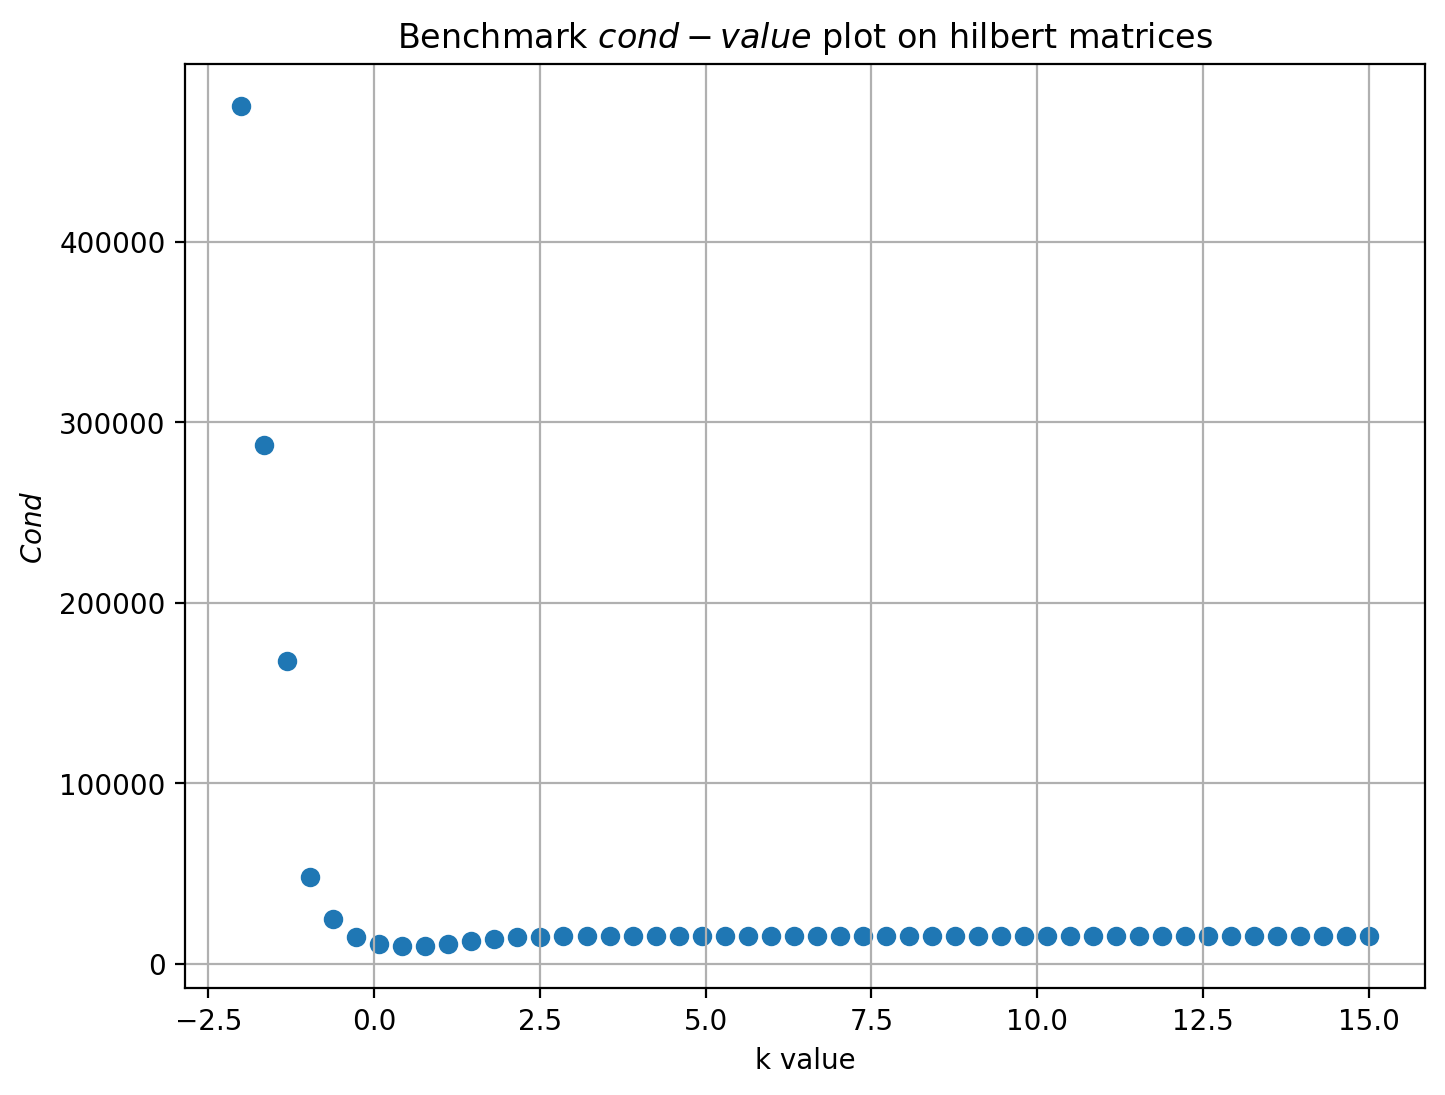

In [45]:
plot_cond_benchmark_hilbert(iterations=100, n=4)

## **5. Benchmark aberration in relation to k-value**

In [46]:
def get_aberration(n: int, k: float, method, gen_method) -> np.array:
    A = gen_method(n, k)
    true_x = get_true_x(len(A))
    return np.linalg.norm(true_x - method(A, A @ true_x))

In [47]:
def plot_aberration(iterations: int, n: int, method=solve_gauss_lead_selection, gen_method=generate_matrix, k_start=-2, k_end=15):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    x_range = np.linspace(k_start, k_end, 50)
    conds = [np.mean([get_aberration(n, k, method, gen_method) for _ in range(iterations)]) for k in x_range]
    ax.scatter(x=x_range, y=get_clear_seq(conds))
    ax.set(xlabel='k value', ylabel='$\Delta x$', title='Benchmark aberration plot')
    ax.grid()
    plt.show()

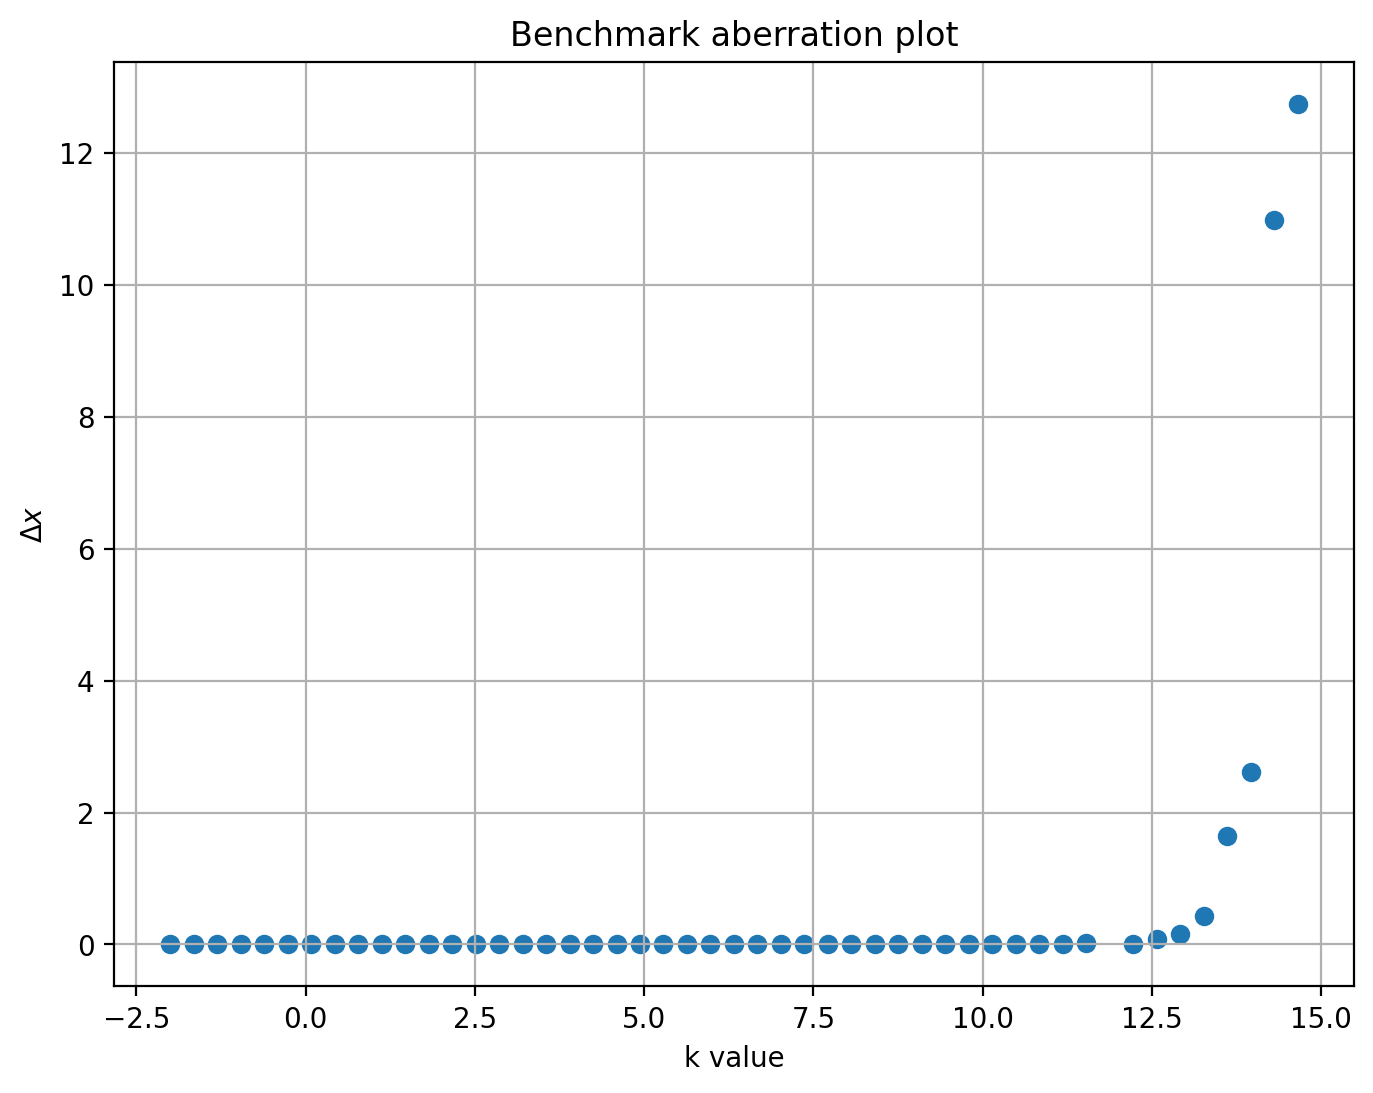

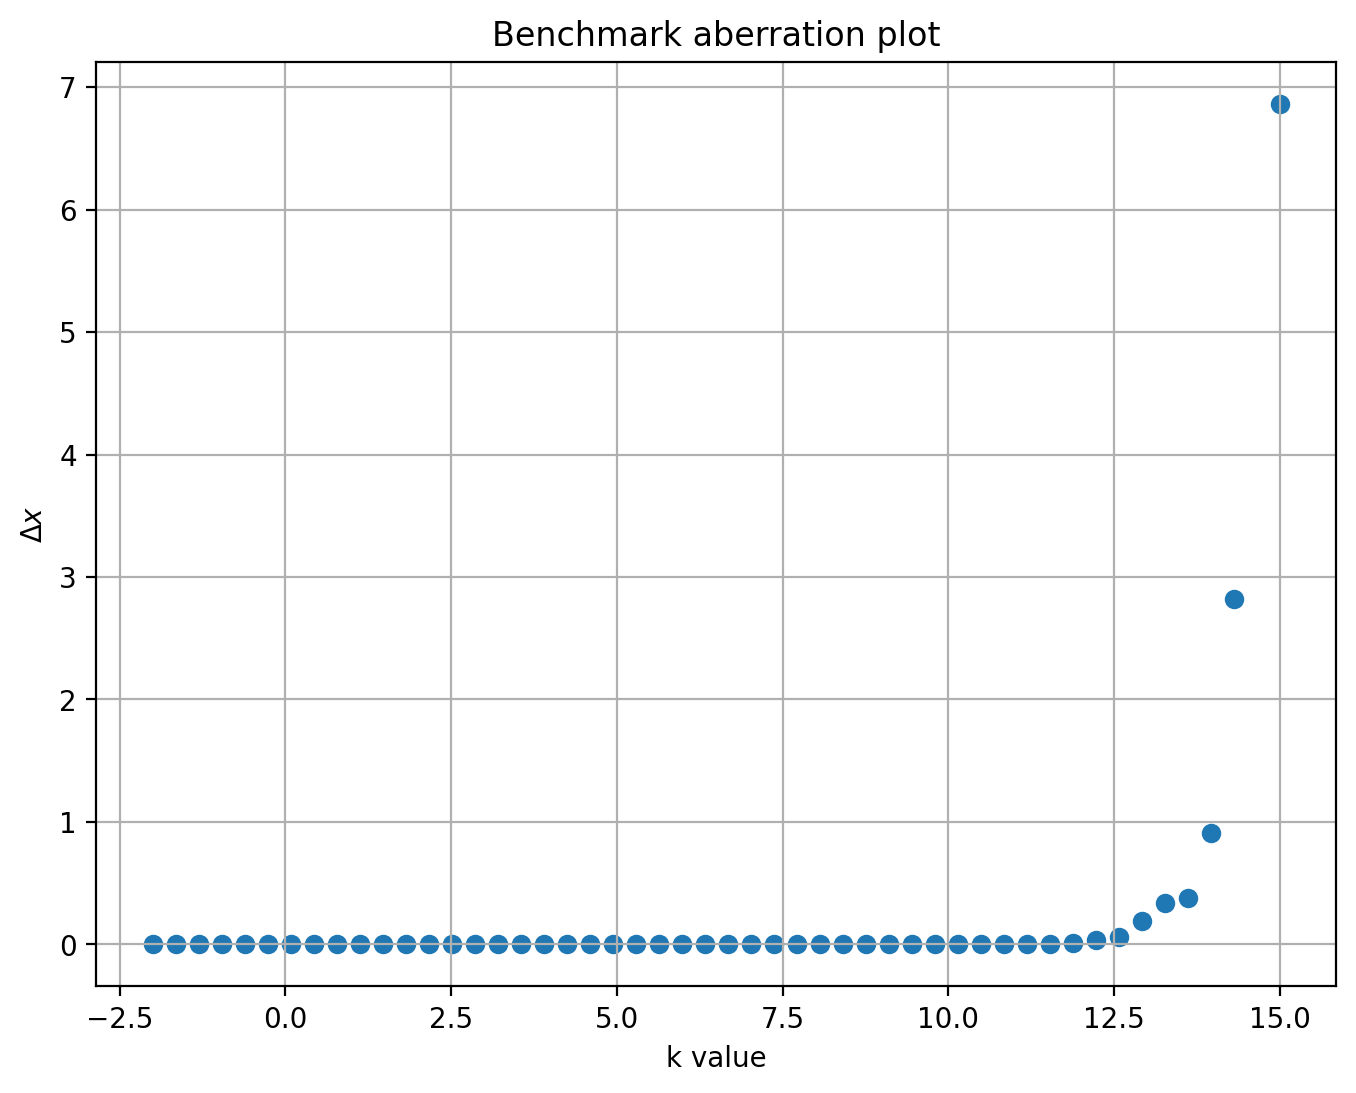

In [48]:
plot_aberration(5, n=6, method=solve_gauss_lead_selection)
plot_aberration(5, n=6, method=solve_lu_decomposition)

In [49]:
def plot_aberration_benchmark(iterations: int, n: int, methods, gen_method=generate_matrix, k_start=-2, k_end=2):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    x_range = np.linspace(k_start, k_end, 50)
    for method in methods:
        ax.plot(x_range, 
               [np.mean([get_aberration(n, k, method[0], gen_method) for _ in range(iterations)]) for k in x_range],
               label=f"{method[1]}")
    ax.set(xlabel='k value', ylabel='$\Delta x$', title='Benchmark aberration plot')
    ax.grid()
    ax.legend()
    plt.show()

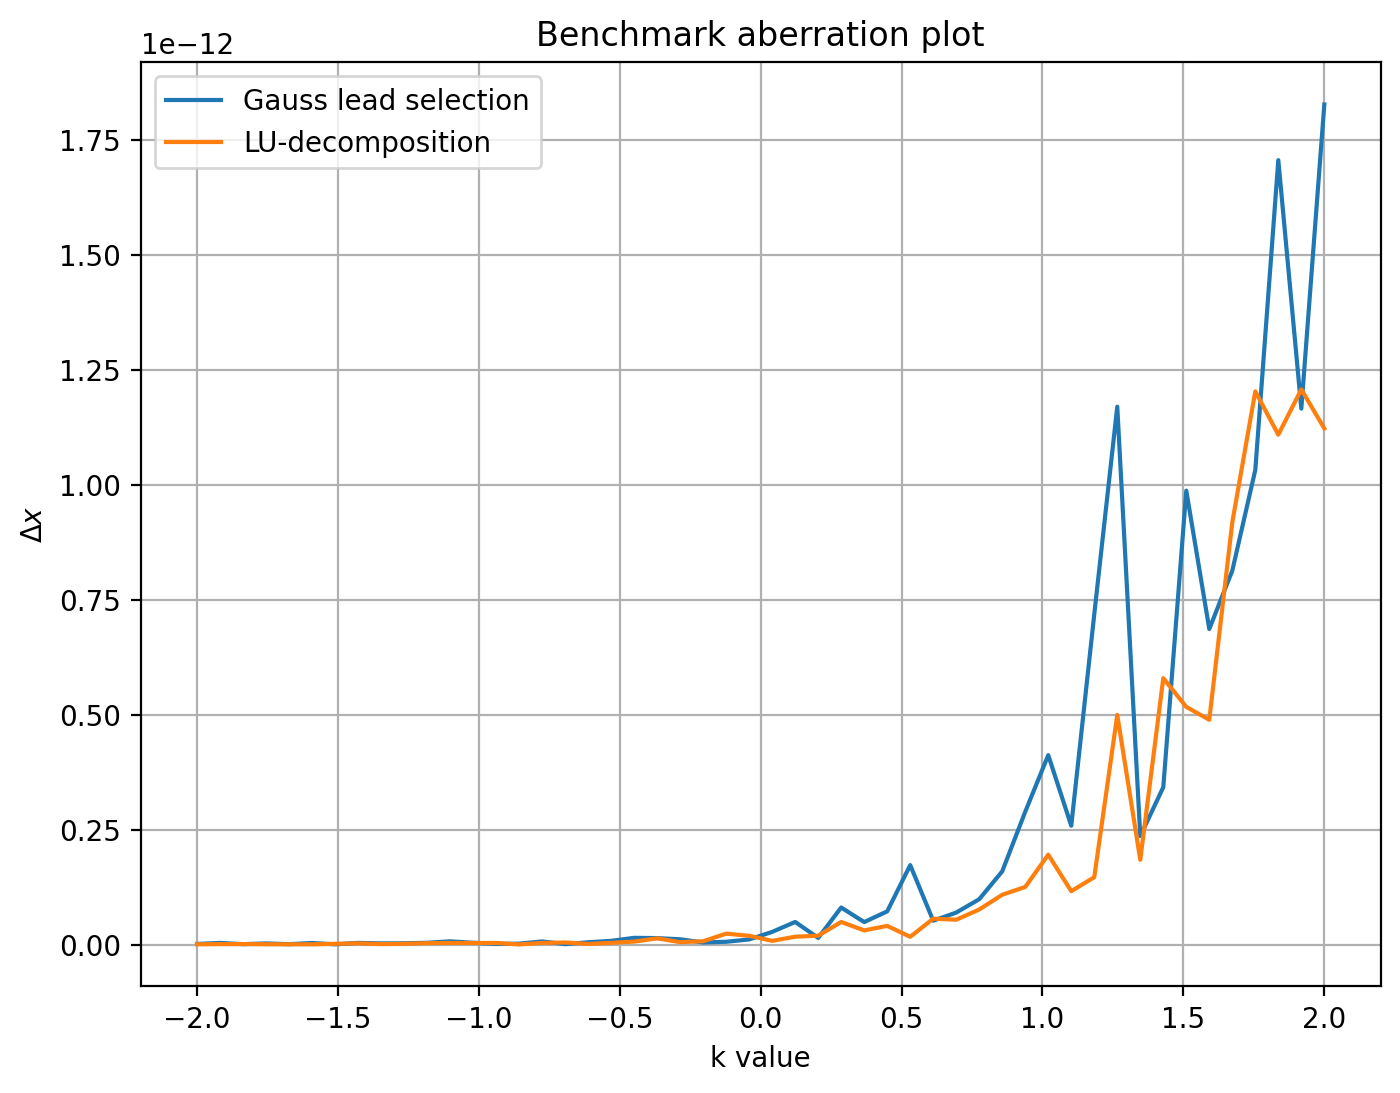

In [50]:
plot_aberration_benchmark(5, n=6, 
                          methods=[[solve_gauss_lead_selection, "Gauss lead selection"], 
                                   [solve_lu_decomposition, "LU-decomposition"]])